# Correcting batch effect in transcriptomics data

We have previously identified that the batch correction with standard batch correction methods has not worked as intended in our transcriptomics data. We propose a new approach, that encompasses some state-of-the-art methods, but also some added steps that allowed us to handle the batch effect in this dataset.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from inmoose.pycombat import pycombat_seq

# Custom functions
from sparc_multiomics.plotting import pannel_plot
from sparc_multiomics.batch_correction import assess_intra_group_unique_value_abundance

## Load data

Loading the collapsed version of the metadata, this will allow us to plot out the features against the metadata. Rows without transcirptomics information are dropped, for this purpose.

In [3]:
collapsed_metadata = pd.read_parquet("collapsed_metadata.parquet")
collapsed_metadata = collapsed_metadata.dropna(subset=["transcriptomics"])
metadata_columns = collapsed_metadata.columns

In [7]:
plot_columns = [
    "sex",
    "diagnosis",
    "endo_category",
    "characteristics_bio_material",
    "macroscopic_appearance",
    "scdai_score",
    "mayo_9_score",
    "disease_activity_60",
    "perianal",
    "abdominal_pain_score",
    "global_assessment_score",
    "rectal_bleeding_score",
    "simple_tissue",
    "batch",
    "moa",
    "medication",
]

## Deploy low variance feature correction

We load the transcriptomics data after normalization and factor size multiplication.

In [8]:
transposed_processed_genes_by_samples_df = pd.read_parquet(
    "transcriptomics_pydeseq_corrected.parquet"
)
usable_columns = list(transposed_processed_genes_by_samples_df.columns)

Next, we rename the columns to their gene name only, meaning we will have duplicated columns, since a single gene name can have multiple gene ids. 

In [9]:
rename_dictionary = {}
for current_column_name in transposed_processed_genes_by_samples_df.drop(
    columns=["sample_id", "batch"]
).columns:
    split_current_column_name = current_column_name.split("_")
    single_column_name = "_".join(split_current_column_name[0:-1])
    rename_dictionary[current_column_name] = single_column_name
simplified_transposed_processed_genes_by_samples_df = (
    transposed_processed_genes_by_samples_df.rename(rename_dictionary, axis=1)
)
simplified_transposed_processed_genes_by_samples_df.head()

,7SK,7SK,7SK,7SK,7SK,7SK,7SK,A1BG-AS1,A1BG,A1CF,...,ZYG11B,ZYXP1,ZYX,ZZEF1,ZZZ3,hsa-mir-1253,hsa-mir-423,snoZ196,sample_id,batch
0,1.0,1.0,1.0,49.0,3.0,1.0,1.0,46.0,10.0,2145.0,...,1532.0,1.0,3119.0,3955.0,1014.0,1.0,1.0,13.0,8051337379,sparc-genewiz-2022
1,1.0,1.0,1.0,22.0,1.0,1.0,1.0,76.0,11.0,3153.0,...,1771.0,1.0,3199.0,7340.0,832.0,1.0,1.0,9.0,8051350156,sparc-genewiz-2022
2,1.0,2.0,1.0,42.0,1.0,1.0,1.0,48.0,5.0,7194.0,...,1941.0,1.0,3594.0,7702.0,1125.0,1.0,1.0,8.0,8051350157,sparc-genewiz-2022
3,1.0,1.0,1.0,35.0,1.0,1.0,1.0,19.0,11.0,5806.0,...,2894.0,1.0,2778.0,8070.0,1102.0,1.0,1.0,4.0,8051350158,sparc-genewiz-2022
4,1.0,1.0,1.0,29.0,1.0,1.0,1.0,49.0,5.0,7690.0,...,2751.0,1.0,3134.0,8588.0,1398.0,1.0,1.0,5.0,8051350159,sparc-genewiz-2022


Now, we sum the counts of the columns with the same name, and assign each gene name a column, with the summed values of the multiple possible gene ids, when there were more than one. The columns without gene name are dropped.

In [10]:
# kr-collapse
summed_columns = {}
for index, col in tqdm(
    enumerate(
        simplified_transposed_processed_genes_by_samples_df.drop(
            columns=["sample_id", "batch"]
        )
    )
):
    current_values = simplified_transposed_processed_genes_by_samples_df.iloc[
        :, index
    ].values
    if col not in summed_columns:
        summed_columns[col] = current_values
    else:
        summed_columns[col] = np.add(summed_columns[col], current_values)

grouped_df = pd.DataFrame(summed_columns)
grouped_df[
    ["sample_id", "batch"]
] = simplified_transposed_processed_genes_by_samples_df[["sample_id", "batch"]]

40384it [00:01, 34415.70it/s]


Now, we assess the abundance of unique values accross features, against the `batch` variable, and plot the distribution.

In [11]:
intra_batch_abundance_mask = assess_intra_group_unique_value_abundance(
    grouped_df.drop(columns=["sample_id"]), "batch"
)

<Axes: ylabel='Count'>

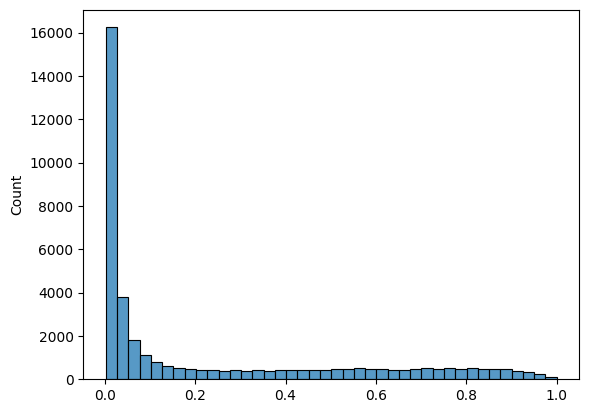

In [12]:
sns.histplot(intra_batch_abundance_mask)

Based on the plot, as well as multiple attempts, we arrive at the threshold of 5% relative abundance, meaning we will be dropping the features in which the average percentage of unique values per batch is inferior to 5%.

In [13]:
only_relevant = intra_batch_abundance_mask[intra_batch_abundance_mask > 0.05]
filtered_grouped_df = pd.concat(
    [grouped_df[only_relevant.index], grouped_df[["sample_id", "batch"]]], axis=1
)

We now remerge the features after processing with the metadata to have access to the metadata columns, perform PCA for visualization and plot the results. We can now see that the batches are clearly bundled into two groups of two.

In [14]:
merged_corrected_data = filtered_grouped_df.merge(
    collapsed_metadata.drop(columns=["batch"]),
    left_on="sample_id",
    right_on="transcriptomics",
    how="right",
)

only_features = merged_corrected_data.drop(
    columns=list(metadata_columns) + ["sample_id"]
)
scaled_features = pd.DataFrame(
    StandardScaler().fit_transform(only_features), columns=only_features.columns
)

number_of_components = 2  # This is just for visualization, so two components is enough
PCA_object = PCA(n_components=number_of_components)
components_names = [f"PC{i}" for i in range(1, number_of_components + 1)]
PCA_object.fit(scaled_features)

processed_features = pd.DataFrame(
    PCA_object.transform(scaled_features),
    columns=components_names,
)

processed_features_ands_ids = pd.concat(
    [processed_features, merged_corrected_data[metadata_columns]], axis=1
)

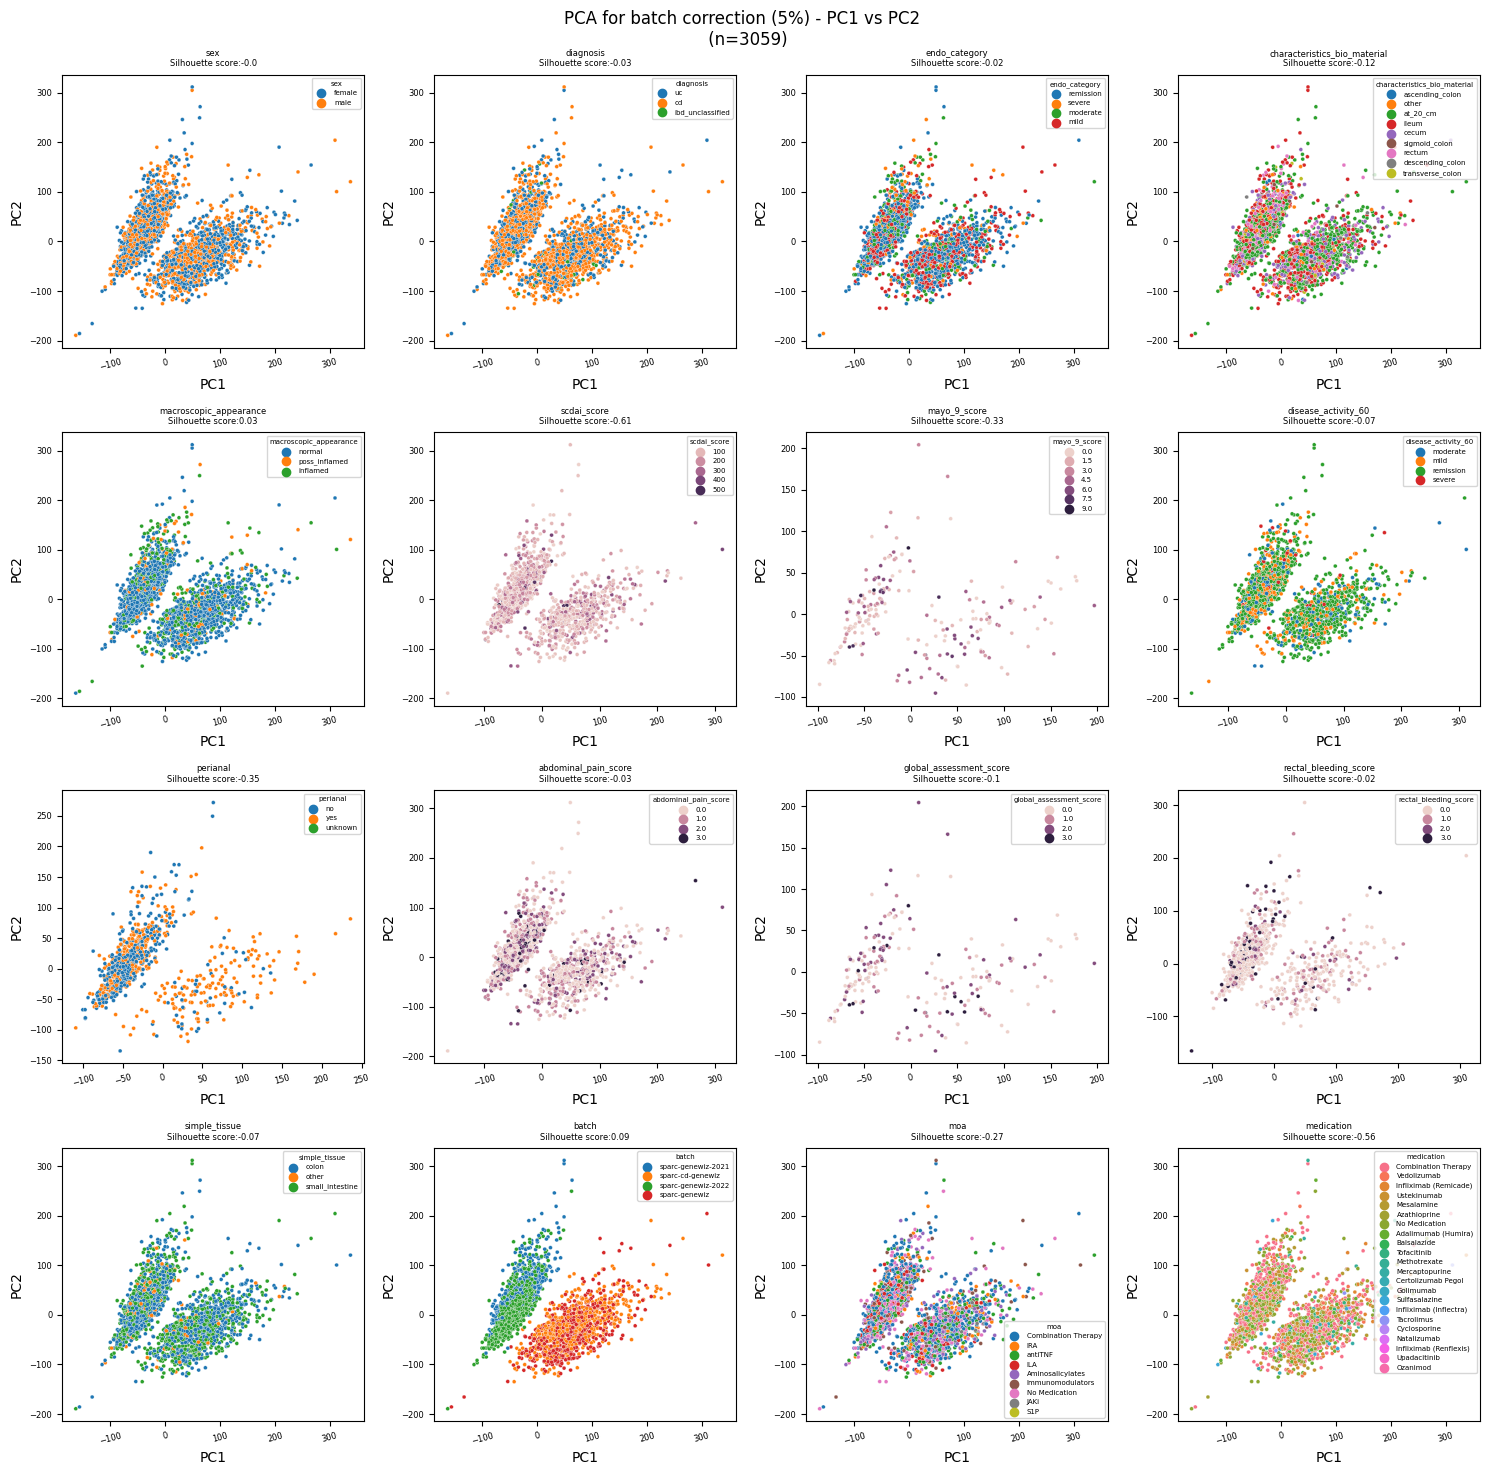

In [15]:
pannel_plot(
    processed_features_ands_ids,
    plot_columns,
    title_text="PCA for batch correction (5%)",
    mode="agglomeration",
    x_variable="PC1",
    y_variable="PC2",
)

## Correction with inmoose

We iteratively run inmoose an correct one batch at a time, performing **sequential batch correction**, after removing the features with low abundance.

In [16]:
unique_batches = [
    "sparc-genewiz-2021",
    "sparc-genewiz-2022",
    "sparc-cd-genewiz",
    "sparc-genewiz",
]
original_batch = filtered_grouped_df["batch"]
current_subset = filtered_grouped_df.drop(columns=["sample_id", "batch"]).transpose()
current_subset = pycombat_seq(
    current_subset,
    original_batch,
)

[INFO] Found 4 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Estimating dispersions


[INFO] Fitting the GLM model
[INFO] shrinkage off - using GLM estimates for parameters
[INFO] Adjusting the data


We format the pycombat results to be written.

In [17]:
pycombat_results = current_subset.transpose()
pycombat_results["original_batch"] = original_batch
pycombat_results["sample_id"] = filtered_grouped_df["sample_id"]

## Correction evaluation

We first reattach the pycombat results to the metadata, such that we can assess whether or not the correction worked.

In [18]:
# kr-collapse
pycombat_merged_corrected_data = pycombat_results.merge(
    collapsed_metadata,
    left_on="sample_id",
    right_on="transcriptomics",
    how="right",
)

pycombat_only_features = pycombat_merged_corrected_data.drop(
    columns=list(metadata_columns) + ["sample_id", "original_batch"]
)
pycombat_scaled_features = pd.DataFrame(
    StandardScaler().fit_transform(pycombat_only_features),
    columns=pycombat_only_features.columns,
)

number_of_components = 2
PCA_object = PCA(n_components=number_of_components)
components_names = [f"PC{i}" for i in range(1, number_of_components + 1)]
PCA_object.fit(pycombat_scaled_features)

pycombat_processed_features = pd.DataFrame(
    PCA_object.transform(pycombat_scaled_features),
    columns=components_names,
)

pycombat_processed_features_ands_ids = pd.concat(
    [pycombat_processed_features, pycombat_merged_corrected_data[metadata_columns]],
    axis=1,
)

### Mutual Information scores

We run mutual information scoring to check whether any/which features retain their bias towards the batch variable after batch correction.

In [19]:
# kr-collapse
mutual_info_scores = mutual_info_classif(
    pycombat_scaled_features, pycombat_merged_corrected_data["original_batch"]
)

<Axes: ylabel='Count'>

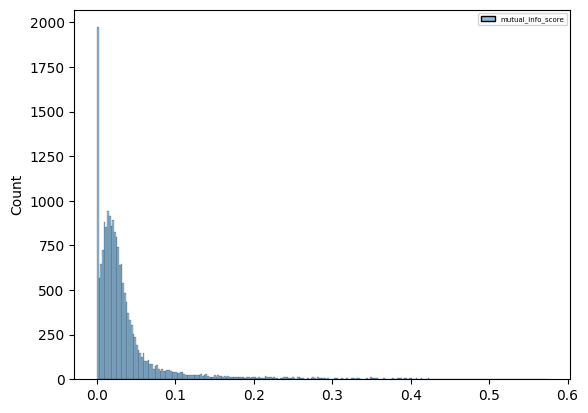

In [20]:
# kr-collapse
mutual_info_scores_df = pd.DataFrame(
    mutual_info_scores,
    index=pycombat_scaled_features.columns,
    columns=["mutual_info_score"],
)
mutual_info_scores_df = mutual_info_scores_df.sort_values(
    by="mutual_info_score", ascending=False
)
sns.histplot(mutual_info_scores_df)

We also plot the values, as before, to have a visual display on whether we can still see the features clustering by batch.

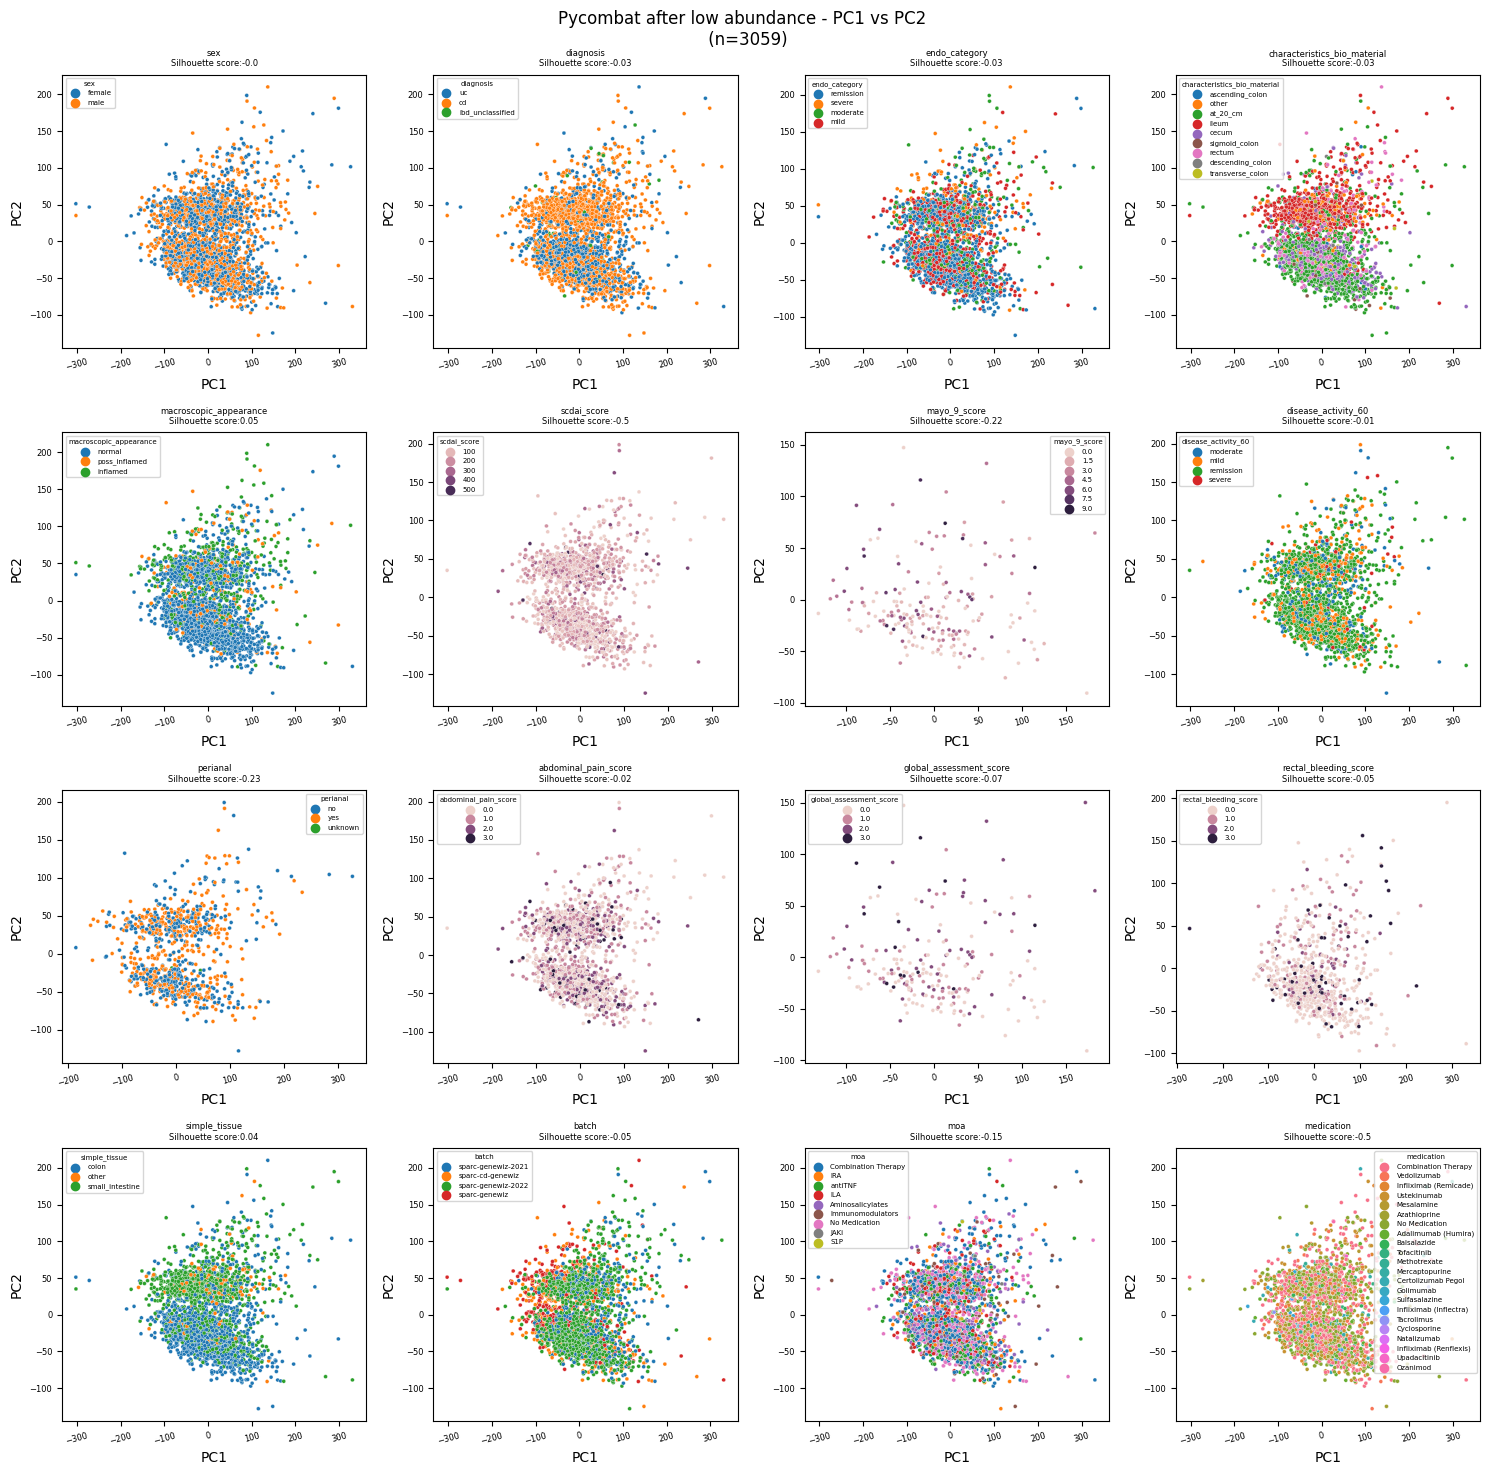

In [21]:
pannel_plot(
    pycombat_processed_features_ands_ids,
    plot_columns,
    title_text="Pycombat after low abundance",
    mode="agglomeration",
    x_variable="PC1",
    y_variable="PC2",
)

## Writing the processed transcriptomics data

In [23]:
pycombat_results.to_parquet("transcriptomics_batch_corrected.parquet")